
# CUNY MSDS DATA620 - Web Analytics

# Project 4 | Stock Market Prediction using Social Network Analysis
## Prof: Alain Ledonwong
## Team1 : Tage Singh, Deepak Sharma, Ramnivas Singh


## Objective
Project should incorporate one or both of the two main themes of this course: network analysis and text processing. 
Show all of work in a coherent workflow, and in a reproducible format, such as an IPython Notebook or an R Markdown document. If building a model or models, explain how  evaluate the “goodness” of the chosen model and parameters. 


## Introduction

The prediction of stock markets is regarded as a challenging task.The stock market is the most popular investing places for the users. Because of its expected high profit. Recently forecasting stock market returns gaining more attention.  

Data analysis is the way of predicting future value if future stocks prices will increase or decrease. The main objective of this project is to analyze price movement with the sentiments (tweets). 

We have used Text Classification method for sentiment analysis.

## Analysis Questions

1.	How can classification method be enhanced for more accuracy of tweets?
2.	How can classification method describe the relationship between twitter sentiments and the stock market movement?
3.	Is it possible to develop a tweet classification system that can analyze tweets for stock market prediction?


## Implementation Steps
- Scraping News from Website of Nasdaq site and apply NLP to extract required information
- Use natural language processing function like tokenize to parse test
- Use Social network analysis concepts to mine and generate graph dataset
- To use island method to create network graph for analysis
- Correlate centrality measures with the stock price movements

## Data source:
- The first data for this application contains total 46 cases of positive and negative definition from the web http://positivewordsresearch.com/sentiment-analysis-resources/#content 
- Second data contains total 3389 cases of positive and negative definition from Twitter 
- The dataset is the latest news for the specific required stock shares or index. https://www.nasdaq.com
- The dataset of stock close price is from scraping the website of yahoo.
- [Twitter Sentiment](https://twitter.com) - A _term > sentiment-score_, cases of positive and negative words 
- [Nasdaq News](https://www.nasdaq.com/symbol/aapl/news-headlines) Scraped the latest news for items in the portfolio
- [Yahoo Stock Prices](https://finance.yahoo.com/quote/) Manually downloaded historical price information

In [1]:
import numpy as np
import networkx as nx
from networkx.algorithms import bipartite
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import csv
import time
import requests
from bs4 import BeautifulSoup
import re
import seaborn
from nltk.tokenize import word_tokenize # or use some other tokenizer
from prettytable import PrettyTable

In [3]:
from nltk.corpus import names as names_ntlk
import nltk
import pandas as pd
import matplotlib
import statistics
import scipy
from IPython.display import display

In [4]:
from urllib.request import urlopen
from sklearn.preprocessing import QuantileTransformer
%matplotlib inline
matplotlib.style.use('ggplot')

# 1.0 Sentiment Data

Simple data of 2 features - _term_ & _score_ from Twitter. We will take a more statistical approach to fix the skewness of our data.
This dataset is persisted at github at the lonk below

In [5]:
sentiment = pd.read_csv('https://raw.githubusercontent.com/rnivas2028/MSDS/Data620/Final-Project/sentiment.csv', encoding='windows-1252')
sentiment.head()

,term,score
0,. #perfection,8.888
1,. #excellent,8.650
2,. #nice,8.421
3,. #fabulous,8.403
4,. #ideal,8.339


In [6]:
sentiment.tail()

,term,score
369196,#rotten,-6.211
369197,#pathetic,-6.302
369198,ipad2,-6.615
369199,#dreadful,-6.764
369200,#unacceptable,-6.925


In [7]:
print(sentiment.term.nunique(), 'unique words are there in this data set')

369199 unique words are there in this data set


## 1.1 Score Normalization

We observed high scoring skewness in the negative direction. To minimize this problem we will use a Quantile Transformer to bring the distribution to normal as close as possible.


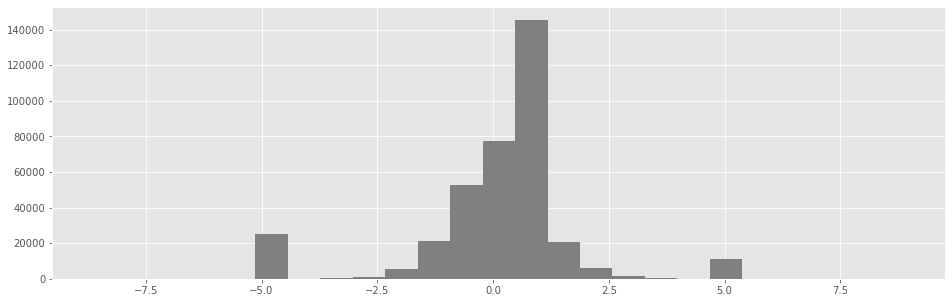

In [8]:
from numpy import exp
from numpy.random import randn
from sklearn.preprocessing import QuantileTransformer
from matplotlib import pyplot
pyplot.figure(figsize=(16,5))
pyplot.hist(sentiment.score, bins=25, color='grey')
pyplot.show()

Normalize the scores to make the interpretation and labeling statistically significant

In [9]:
sentiment['norm_score'] = QuantileTransformer(output_distribution='normal').fit_transform(sentiment.score.values.reshape(-1, 1))

The graph below represents a normalized distribution of the scores.

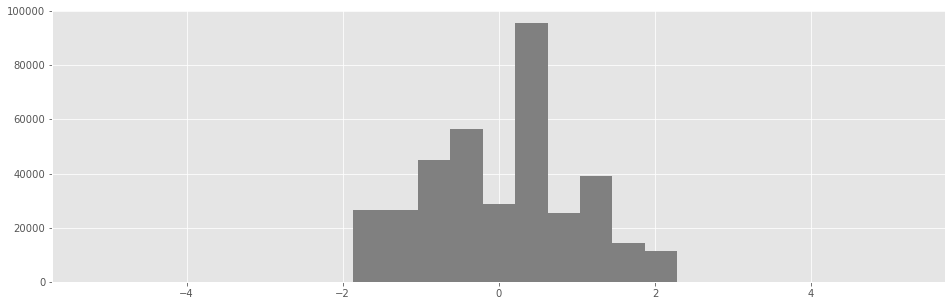

In [10]:
pyplot.figure(figsize=(16,5))
pyplot.hist(sentiment.norm_score, bins=25, color='grey')
pyplot.show()

## 1.2 Quantile distribution based label setting

We have used quantile function which is associated with a probability distribution of random variable, specifies the value of the random variable such that the probability of the variable being less than or equal to that value equals the given probability.

Since the distribution has been normalized, we will now create custom labels using the 25th and 75th quantile values as our thresholds. Everything in between will be considered as a low impacting news and marked as neutral.
Below are 25% & 75% quantile values 

In [11]:
quants = sentiment.norm_score.quantile([0.25,0.75])
print(quants)

0.25   -0.678433
0.75    0.318969
Name: norm_score, dtype: float64


#### Classify based on the quantiles - negative < 0.25 < neutral < 0.75 < positive

In [12]:
sentiment['label'] = 'neutral'
sentiment.loc[sentiment.norm_score < quants.iloc[0], 'label'] = 'negative' 
sentiment.loc[sentiment.norm_score > quants.iloc[1], 'label']= 'positive' 

<AxesSubplot:xlabel='label'>

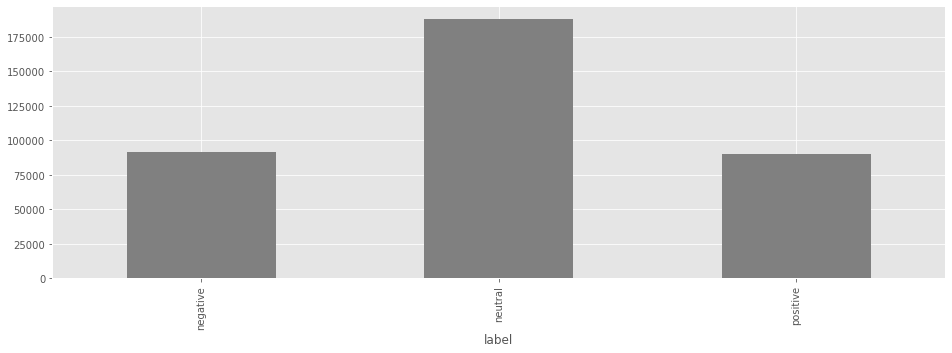

In [13]:
plt.rcParams['figure.figsize'] = [16, 5]
sentiment.groupby('label').count().term.plot(kind='bar', color='grey')

In [14]:
sentiment

,term,score,norm_score,label
0,. #perfection,8.888,5.199338,positive
1,. #excellent,8.650,5.199338,positive
2,. #nice,8.421,5.199338,positive
3,. #fabulous,8.403,4.405916,positive
4,. #ideal,8.339,4.065220,positive
...,...,...,...,...
369196,#rotten,-6.211,-3.208261,negative
369197,#pathetic,-6.302,-3.219230,negative
369198,ipad2,-6.615,-3.260235,negative
369199,#dreadful,-6.764,-3.281859,negative


# 2.0 Standard and Poor's 500 (S&P500)

The Standard and Poor's 500, or simply the S&P 500, is a large-cap measurement stock market index made up of 500 large companies listed on stock exchanges in the United States. It is one of the most commonly followed equity indices. We have loaded S&P500 stocks data from 2018. 

https://seekingalpha.com/article/4185058-50-best-performing-s-and-p-500-stocks-1h-2018

Lets 20 best performing stock portfolio and build a list of companies and their symbols  

In [15]:
 portfolio = ['ADBE', 'STX', 'APC', 'KSS', 'APP','ABMD', 'NFLX', 'TWTR', 'TRIP', 'XL', 'UA', 'ALGN', 'M', 'CMG', 'AMD', 
             'AMZN', 'FOXA', 'NTAP', 'HES', 'HES', 'IDXX']

# 3.0 Nasdaq News Data

We have downloaded 10 latest news for selected tickers and persisted these articles in a file in github

In [16]:
news_df = pd.read_csv('https://raw.githubusercontent.com/rnivas2028/MSDS/Data620/Final-Project/news.csv', encoding='windows-1252')
news_df.Date = pd.to_datetime(news_df.Date)
news_df = news_df.sort_values('Date')
news_df.head()

,Contents,Date,Symbol,Titles,URLS
155,"For Immediate Release Chicago, IL - July...",2018-07-03,STX,zacks industry outlook highlights netapp super...,https://www.nasdaq.com/article/zacks-industry-...
154,International Business Machines IBM has ...,2018-07-03,STX,ibm to digitalize banca carige australian gove...,https://www.nasdaq.com/article/ibm-to-digitali...
135,Reuters @media screen and (max-device-width: ...,2018-07-03,IDXX,us stocks on the movepepsi spero nordstrom st...,https://www.nasdaq.com/article/us-stocks-on-th...
153,"We're just over halfway through 2018, so it's ...",2018-07-03,STX,the 5 best sp 500 high dividend stocks of 2018...,https://www.nasdaq.com/article/the-5-best-sp-5...
66,"We're just over halfway through 2018, so it's ...",2018-07-03,M,the 5 best sp 500 high dividend stocks of 2018...,https://www.nasdaq.com/article/the-5-best-sp-5...


## 3.1 Label Classification

Break down the article contents into individual words/tokens

In [17]:
news_df['tokenized'] = news_df.Contents.apply(lambda row: nltk.word_tokenize(row))

In [18]:
news_df.tokenized.head(10)

155    [For, Immediate, Release, Chicago, ,, IL, -, J...
154    [International, Business, Machines, IBM, has, ...
135    [Reuters, @, media, screen, and, (, max-device...
153    [We, 're, just, over, halfway, through, 2018, ...
66     [We, 're, just, over, halfway, through, 2018, ...
47     [Investors, in, Under, Armour, Inc, (, Symbol,...
152    [What, happened, Shares, of, hard-drive, giant...
44     [What, happened, Shares, of, Under, Armour, (,...
46     [In, this, segment, from, the, Motley, Fool, M...
134    [Reuters, @, media, screen, and, (, max-device...
Name: tokenized, dtype: object

Look up the above tokenized articles in the sentiment dataframe and count matched words to classify with positive or negative sentiment

In [ ]:
pos = []
neg = []
for art in news_df.tokenized:
    pos.append(int(sentiment[sentiment.term.isin(art)].groupby('label').term.count().positive))
    neg.append(int(sentiment[sentiment.term.isin(art)].groupby('label').term.count().negative))

Lets create a label based on the sum of words found in the sentiment list

In [ ]:
news_df['pos'] = pos
news_df['neg'] = neg
news_df['score'] = news_df['pos'] - news_df['neg']
news_df['label'] = np.where(news_df['score'] > 0, 'positive', 'negative')
news_df.head()

Aggregate score by symbol and article date

In [ ]:
sen_news = pd.DataFrame({'score' : news_df.groupby( ["Symbol", "Date"])['score'].sum()}).reset_index()
sen_news.head()

In [ ]:
sen_news.tail()

# 4.0 Yahoo Stock Price

We have downloaded price data of the tickers and persisted these articles in a file in github. This price data is from 2018 with Open, High, Low, Close,Adj Close price 

In [ ]:
prices = pd.read_csv('https://raw.githubusercontent.com/rnivas2028/MSDS/Data620/Final-Project/prices.csv')
prices.Date = pd.to_datetime(prices.Date)
prices = prices.sort_values('Date')
prices.head()

Calculate a new feature change to indicate the difference between opening price and closing price

In [ ]:
prices['change'] = round(prices['Close'] - prices['Open'],2)
prices.head()

In [ ]:
prices.tail()

# 5.0 Merge Sentiment labeled news data with stock price

In [ ]:
stock_sentiment_labeled = sen_news.merge(prices, left_on=['Symbol', 'Date'], right_on=['Symbol', 'Date'], how='outer')
stock_sentiment_labeled =  stock_sentiment_labeled.dropna(subset=['score'], axis='rows')

In [ ]:
stock_sentiment_labeled.head()

In [ ]:
stock_sentiment_labeled.tail()

## 5.1 Price change
Lets list down the price changes for a given ticker

In [ ]:
stock_sentiment_labeled[stock_sentiment_labeled.Symbol == 'ABMD'][['Date', 'score', 'Open','High', 'Low','change']]

In [ ]:
stock_sentiment_labeled[stock_sentiment_labeled.Symbol == 'STX'][['Date', 'score', 'Open','High', 'Low','change']]

In [ ]:
stock_sentiment_labeled[stock_sentiment_labeled.Symbol == 'AMD'][['Date', 'score', 'Open','High', 'Low','change']]

In [ ]:
stock_sentiment_labeled[stock_sentiment_labeled.Symbol == 'UA'][['Date', 'score', 'Open','High', 'Low','change']]

In [ ]:
stock_sentiment_labeled[stock_sentiment_labeled.Symbol == 'TWTR'][['Date', 'score', 'Open','High', 'Low','change']]

# 6.0 Plot Sentiment & Price Time Series

Following method is developed to plot Sentiment & Price Time Series data

In [ ]:
def plot_sentiments(symbol):
    plt.figure(figsize=(16,8))
    x = stock_sentiment_labeled[stock_sentiment_labeled.Symbol == symbol].Date
    y1 = stock_sentiment_labeled[stock_sentiment_labeled.Symbol == symbol].change
    y2 = stock_sentiment_labeled[stock_sentiment_labeled.Symbol == symbol].score
    plt.subplot(2, 1, 1)
    plt.plot(x, y1,  color='blue')
    plt.title('Price Change vs Sentiment')
    plt.ylabel('Stock Price Change')
    plt.subplot(2, 1, 2)
    plt.plot(x, y2,color='green')
    plt.xlabel('Date')
    plt.ylabel('Sentiment')
    plt.show()
    plt.figure(figsize=(16,4))
    ax = sns.regplot(x='score', y='change', color='teal', data=stock_sentiment_labeled[stock_sentiment_labeled.Symbol == symbol], x_estimator=np.mean)
    plt.xlabel('News Sentiment Score')
    plt.ylabel('Open - Close: Price Change')
    plt.title('Price Change vs Sentiment Score')

In [ ]:
plot_sentiments('ABMD')

In [ ]:
plot_sentiments('STX')

In [ ]:
plot_sentiments('AMD')

In [ ]:
plot_sentiments('UA')

# 7.0 Portfolio Networkx 

We have visualised correlations between stocks. As an investor, we are interested in diversifying risk by selecting different types of them. Therefore we want to visualise which stocks behave similarly (positive correlations) or very differently (negative correlations). Using a dataset with the prices of selected stocks over time, we’ll create a graph object to analyze.
We are further checking the direction of stock shares or index to find out any opportunity of investment, like buy stocks in positive intention or sold stocks in negative intention.

#### Networkx Graph
We will use stock as one set of nodes and direction as the other. This should lead us to a bipartite graph.
In addition, there is a weight associated with every edge. The weight represents the lastsale price of stock to create multiple islands.

In [ ]:
tickers = pd.read_csv("https://raw.githubusercontent.com/rnivas2028/MSDS/Data620/Final-Project/ticker.csv")
tickers.head()

In [ ]:
tickers.tail()

## 7.1 Bipartite Graph
Networkx graph with two sets of bipartite nodes (tickers and sentiments=negative and positive)

In [ ]:
G = nx.Graph()
G.add_nodes_from(tickers['stock'], bipartite=0)
G.add_nodes_from(tickers['direction'], bipartite=1)
for i in range(len(tickers)):
    G.add_edge(tickers.iloc[i][0], tickers.iloc[i][1], weight=1)
print(nx.info(G))

In [ ]:
# Checking the stucture of the graph
nx.is_connected(G), nx.is_bipartite(G)

In [ ]:
nx.draw(G,with_labels=False)

In [ ]:
weighted_edges = tickers[['stock', 'direction','LastSale']].T.apply(tuple).values.tolist()
records = tickers.to_records(index=False)
result = list(records)
G.add_weighted_edges_from(result)
nx.draw(G,with_labels=True)

In [ ]:
stock_nodes = set(n for n,d in G.nodes(data=True) if d['bipartite']==0)
direction_nodes = set(G) - stock_nodes
direction_nodes

In [ ]:
# Generaing a list of top_nodes(tickers) and bottom_nodes(sentiments)
sentiments_nodes = set(n for n,d in G.nodes(data=True) if d['bipartite']==1)
ticker_nodes = set(G) - sentiments_nodes

## 7.2. Centrality Measures
In the table below we take the bipartite weighted graph and examine centrality measures. 

In [ ]:
def PrintTable(graph):
   degree = nx.degree(graph)
   degree_centrality = nx.degree_centrality(graph)
   betweenness_centrality = nx.betweenness_centrality(graph)
   closeness_centrality = nx.closeness_centrality(graph)
   eigenvector_centrality = nx.eigenvector_centrality_numpy(graph)
   table = [[name,degree[name], round(degree_centrality[name],6), round(betweenness_centrality[name],6),
             round(closeness_centrality[name],6), round(eigenvector_centrality[name],6)] for name in graph.nodes()]
   table = sorted(table,key = lambda x: -x[2])[:10]
   printTable = PrettyTable(['Subject','Degree','Degree Centrality','Betweenness','Closeness','Eigenvector'])
   for i in range(0, len(table)):
       printTable.add_row(table[i])
   return printTable

In [ ]:
#print(PrintTable(G))

In [ ]:
projected_graph_sentiments = nx.bipartite.weighted_projected_graph(G, sentiments_nodes)
connected_component_subgraphs = (projected_graph_sentiments.subgraph(c) for c in nx.connected_components(projected_graph_sentiments))
connected_component_sentiments = max(connected_component_subgraphs, key=len)
projected_graph_sentiments.nodes()

In [ ]:
#print(PrintTable(connected_component_sentiments))

In [ ]:
projected_graph_ticker = nx.bipartite.weighted_projected_graph(G, ticker_nodes)
connected_component_subgraphs = (projected_graph_ticker.subgraph(c) for c in nx.connected_components(projected_graph_ticker))
connected_component_ticker = max(connected_component_subgraphs, key=len)

In [ ]:
print(PrintTable(connected_component_ticker))

In [ ]:
stock_nodes = set(n for n,d in G.nodes(data=True) if d['bipartite']==0)
connected_component_stocks = nx.bipartite.weighted_projected_graph(G, stock_nodes)

## 7.3 Island method
We have used tthe method below to use island method for further analysis

In [ ]:
## Implementing the Island Method to look for important subgroups. ##
def trim_edges(g, weight = 1):
    # Implements a trimming of the graph edges for the Island Analysis
    island_graph = nx.Graph()
    for f, to, edata in g.edges(data=True):
        if edata['weight'] > weight:
            island_graph.add_edge(f,to)
    return island_graph

    # Iterates through the graph removing edges and returning the number of edges removed and
    #  the trimmed graph
def island_method(g, iterations=5, weight=1):
    weights = [edata['weight'] for f, to, edata in g.edges(data=True)]
    weights
    mn=int(min(weights)) if int(min(weights)) > weight else weight
    mx=int(max(weights))
    #compute the size of the step, so we get a reasonable step in iterations
    step=int((mx-mn)/(iterations))
    return [[threshold, trim_edges(g, threshold)] for threshold in range(mn,mx,step)]

A threshold value of 1 results in a network of 829 stocks and 2 connected components. As we increase the threshold, number of the stocks are filters and connected network still remain 2. At maximum threashold network left with 2 stocks and 1 connected components

In [ ]:
islands = island_method(G, iterations = 5)
for island in islands:
    print('   %d               %2d                   %2d' 
          %(island[0], len(island[1]), len(list(nx.connected_components(island[1])))))

In [ ]:
def plot_network(threshold):
    ## Plotting created by the island analysis
    pc = trim_edges(G, threshold)
    from nxviz import CircosPlot
    nx.draw(pc,with_labels=True,alpha=.50, font_size=18)

In [ ]:
plot_network(1)

In [ ]:
plot_network(404)

In [ ]:
plot_network(807)

In [ ]:
plot_network(1210)

In [ ]:
plot_network(2016)

## 7.4 Examining Nodes
Now that we have our graph constructed we can examine the two types of nodes. Notice that the type of crime isn't provided; there is simply a number value given to each crime event.

It has 6 iterations on the biggest connected graph from the entire dataset. Although it is only positive and negative of direction nodes, but it is a good way to show the edge weight by lastsale price. 

In [ ]:
connected_components_negative = sorted(nx.connected_components(G), key = len, reverse=True)[1]
print(len(connected_components_negative), 'Stocke with Negative sentiments')

In [ ]:
connected_components_positive = sorted(nx.connected_components(G), key = len, reverse=True)[0]
print(len(connected_components_positive), 'Stocke with Positive sentiments')

### 7.4.1 First Island Visualization
For the weight of all range stock price, it has 521 stock shares with one positive direction.

In [ ]:
node_colors = []
for n in islands[0][1].nodes(data=True):
    if n[0] in stock_nodes:
        node_colors.append('red')
    else:
        node_colors.append('grey')

In [ ]:
plt.rcParams['figure.figsize'] = [16, 12]
pos = nx.spring_layout(islands[0][1], k=2) # k=2 values helps spread the nodes
# Degree calculations to denote the size of nodes
degree = dict(nx.degree(islands[0][1]))
degree_graph = nx.draw_networkx(islands[0][1], 
                                pos=pos,
                                node_color=node_colors,
                                node_size=np.multiply(list(degree.values()), 400), # multiply degree by 400 for better resolution
                                with_labels=True, 
                                width=0.2)
# Remove axis
limits=plt.axis('off')

### 7.4.2 Second Island Visualization
For the weight of stock price more than 404, it has 7 stock with one positive direction.

In [ ]:
# Create a list of colors based on the node name

node_colors = []
for n in islands[1][1].nodes(data=True):
    if n[0] in stock_nodes:
        node_colors.append('#bf8a40')
    else:
        node_colors.append('#40bf80')

In [ ]:
plt.rcParams['figure.figsize'] = [16, 12]

pos = nx.spring_layout(islands[1][1], k=1) # k=2 values helps spread the nodes

# Degree calculations to denote the size of nodes
degree = dict(nx.degree(islands[1][1]))


degree_graph = nx.draw_networkx(islands[1][1], 
                                pos=pos,
                                node_color=node_colors,
                                node_size=np.multiply(list(degree.values()), 400), # multiply degree by 400 for better resolution
                                with_labels=True, 
                                width=0.2)

# Remove axis
limits=plt.axis('off')

For the second island visualization, it has 7 stock shares nodes with one positive direction node, and the closeness nodes with central positive node show the weight of price value, like amazon and google are highest value of price comparing with all selected stocks.

# 8.0 Conclusion
- Already, we know the evaluation of the return on investment in the share market through any one of the traditional techniques 

- We have used the result of sentiment dataset to create the weighted network, according to the weight and positive direction, we can make our investing decision for the price weighting, like closeness central nodes

- We should choose the positive direction of stock shares with proper price for our investiment.

- The return on investment in share market is always uncertain and ambiguity in nature, so that no traditional techniques will give the accurate or appropriate solution

In [ ]:
from IPython.display import YouTubeVideo
YouTubeVideo('https://youtu.be/QO7_IWZ4FhM')

# 9.0 References
[1] Networkx documentation: https://networkx.github.io/documentation/stable/reference/drawing.html \
[2] Fruchterman, T.M. and Reingold, E.M., 1991. Graph drawing by force-directed placement. 1991. Zitiert auf den, p.37.\
[3] Mantegna, R.N., 1999. The European Physical Journal B-Condensed Matter and Complex Systems, 11(1), pp.193-197.\
[4] Financial Network Analytics: https://www.fna.fi/ \
[5] Plotly: https://plot.ly/d3-js-for-python-and-pandas-charts/ \
[6] Wenyue Sun, Chuan Tian, Guang Yang, 2015, Network Analysis of the Stock Market \
[7] Sentiments data : www.twittter.com \
[8] News articles data : www.nasdaq.com \
[9] Price data : www.yahoo.com